# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

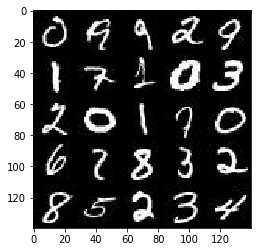

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

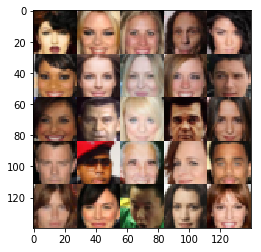

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_dim = (image_width, image_height, image_channels)
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [15]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    keep_probability = 0.8
    kernel_init = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x1 for MNIST or 28x28x3 for CelebA
        # No batch normalization on first layer
        x1 = tf.layers.conv2d(images, 64, 4, strides=2, padding='same', kernel_initializer=kernel_init)
        x1 = tf.nn.dropout(x1, keep_probability)
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64 now
        #print('discriminator x1 shape ', x1.shape)
        
        x2 = tf.layers.conv2d(relu1, 128, 4, strides=2, padding='same', kernel_initializer=kernel_init)
        x2 = tf.nn.dropout(x2, keep_probability)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128 now
        #print('discriminator x2 shape ', x2.shape)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=kernel_init)
        x3 = tf.nn.dropout(x3, keep_probability)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256 now
        #print('discriminator x3 shape ', x3.shape)

        # Flatten it
        #flat = tf.reshape(relu2, (-1, 7*7*128)) before adding additional layer
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [18]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    kernel_init = tf.contrib.layers.xavier_initializer()
    
    # print(out_channel_dim) <- value of 5 in unit test
    #output_dim = (28, 28, out_channel_dim)
    
    with tf.variable_scope('generator', reuse=not is_train): # <- not sure if reuse during training
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='valid', kernel_initializer=kernel_init)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same', kernel_initializer=kernel_init)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same', 
                                            kernel_initializer=kernel_init)
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #print(data_shape) # <- (6000, 28, 28, 1) for MNIST training
    #print(data_image_mode) # <- "L" for MNIST training
    
    if (data_image_mode == "L"):
        out_channel_dim=1
    else:
        out_channel_dim=3
    
    #tf.reset_default_graph()
    # model_inputs(image_width, image_height, image_channels, z_dim)
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    lr = learning_rate
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    print_every=10
    show_every=100
    samples, losses = [], []
    steps=0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # print(batch_images.shape) # <- (128, 28, 28, 1) for MNIST
                #batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                # The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5
                #  of 28x28 dimensional images.
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z=np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                #_ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images}) saw suggestion to run 2x
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f} ...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    #show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                    
        # show images at end of training
        #show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)
        show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.7031 ... Generator Loss: 9.5786
Epoch 1/2... Discriminator Loss: 2.4839 ... Generator Loss: 5.6146
Epoch 1/2... Discriminator Loss: 1.3392 ... Generator Loss: 1.4285
Epoch 1/2... Discriminator Loss: 1.1454 ... Generator Loss: 2.0123
Epoch 1/2... Discriminator Loss: 1.8887 ... Generator Loss: 3.9031
Epoch 1/2... Discriminator Loss: 1.2433 ... Generator Loss: 3.4194
Epoch 1/2... Discriminator Loss: 1.0306 ... Generator Loss: 4.5709
Epoch 1/2... Discriminator Loss: 1.6250 ... Generator Loss: 4.3980
Epoch 1/2... Discriminator Loss: 1.5368 ... Generator Loss: 2.8373
Epoch 1/2... Discriminator Loss: 1.2708 ... Generator Loss: 2.5282


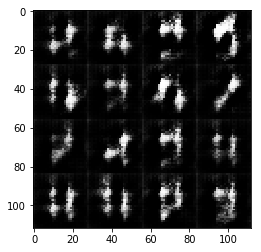

Epoch 1/2... Discriminator Loss: 1.6407 ... Generator Loss: 2.3743
Epoch 1/2... Discriminator Loss: 1.5291 ... Generator Loss: 1.8545
Epoch 1/2... Discriminator Loss: 1.4054 ... Generator Loss: 0.9532
Epoch 1/2... Discriminator Loss: 1.9426 ... Generator Loss: 2.0046
Epoch 1/2... Discriminator Loss: 1.4709 ... Generator Loss: 1.2969
Epoch 1/2... Discriminator Loss: 1.6227 ... Generator Loss: 1.2490
Epoch 1/2... Discriminator Loss: 1.1246 ... Generator Loss: 1.0631
Epoch 1/2... Discriminator Loss: 1.7783 ... Generator Loss: 0.2865
Epoch 1/2... Discriminator Loss: 1.6212 ... Generator Loss: 0.3157
Epoch 1/2... Discriminator Loss: 1.3653 ... Generator Loss: 0.5040


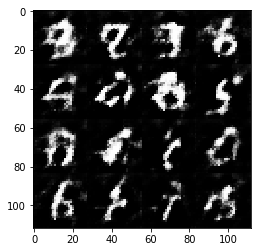

Epoch 1/2... Discriminator Loss: 1.4699 ... Generator Loss: 0.4566
Epoch 1/2... Discriminator Loss: 1.4462 ... Generator Loss: 0.4220
Epoch 1/2... Discriminator Loss: 1.6446 ... Generator Loss: 0.3420
Epoch 1/2... Discriminator Loss: 1.6119 ... Generator Loss: 0.3547
Epoch 1/2... Discriminator Loss: 1.6327 ... Generator Loss: 0.3511
Epoch 1/2... Discriminator Loss: 1.7161 ... Generator Loss: 0.3307
Epoch 1/2... Discriminator Loss: 1.4712 ... Generator Loss: 0.4483
Epoch 1/2... Discriminator Loss: 1.6329 ... Generator Loss: 0.3626
Epoch 1/2... Discriminator Loss: 1.4326 ... Generator Loss: 0.4471
Epoch 1/2... Discriminator Loss: 1.5295 ... Generator Loss: 0.3628


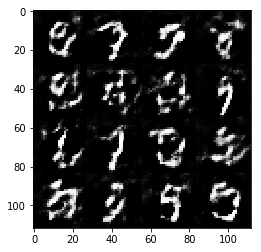

Epoch 1/2... Discriminator Loss: 1.5708 ... Generator Loss: 0.3692
Epoch 1/2... Discriminator Loss: 1.3687 ... Generator Loss: 0.5320
Epoch 1/2... Discriminator Loss: 1.4533 ... Generator Loss: 0.4067
Epoch 1/2... Discriminator Loss: 1.3760 ... Generator Loss: 0.4090
Epoch 1/2... Discriminator Loss: 1.5554 ... Generator Loss: 0.3863
Epoch 1/2... Discriminator Loss: 1.4000 ... Generator Loss: 0.4187
Epoch 1/2... Discriminator Loss: 1.6609 ... Generator Loss: 0.3238
Epoch 1/2... Discriminator Loss: 1.2559 ... Generator Loss: 0.6626
Epoch 1/2... Discriminator Loss: 1.3960 ... Generator Loss: 0.4408
Epoch 1/2... Discriminator Loss: 1.6364 ... Generator Loss: 0.3295


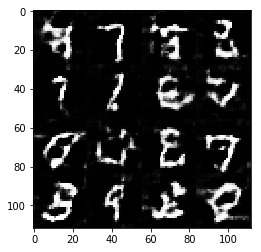

Epoch 1/2... Discriminator Loss: 1.4749 ... Generator Loss: 0.3780
Epoch 1/2... Discriminator Loss: 1.3729 ... Generator Loss: 0.5139
Epoch 1/2... Discriminator Loss: 1.4539 ... Generator Loss: 0.3651
Epoch 1/2... Discriminator Loss: 1.5392 ... Generator Loss: 0.3524
Epoch 1/2... Discriminator Loss: 1.6136 ... Generator Loss: 0.3360
Epoch 1/2... Discriminator Loss: 1.4223 ... Generator Loss: 0.4173
Epoch 1/2... Discriminator Loss: 1.2403 ... Generator Loss: 0.6417
Epoch 1/2... Discriminator Loss: 1.8186 ... Generator Loss: 0.2333
Epoch 1/2... Discriminator Loss: 1.5772 ... Generator Loss: 0.3337
Epoch 1/2... Discriminator Loss: 1.3620 ... Generator Loss: 0.4192


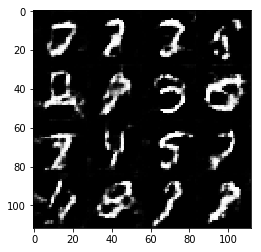

Epoch 1/2... Discriminator Loss: 1.5576 ... Generator Loss: 0.3231
Epoch 1/2... Discriminator Loss: 1.2282 ... Generator Loss: 0.5409
Epoch 1/2... Discriminator Loss: 1.5801 ... Generator Loss: 0.3414
Epoch 1/2... Discriminator Loss: 1.5290 ... Generator Loss: 0.3679
Epoch 1/2... Discriminator Loss: 1.4223 ... Generator Loss: 0.4504
Epoch 1/2... Discriminator Loss: 1.3792 ... Generator Loss: 0.4913
Epoch 1/2... Discriminator Loss: 1.4350 ... Generator Loss: 0.4686
Epoch 1/2... Discriminator Loss: 1.5239 ... Generator Loss: 0.3569
Epoch 1/2... Discriminator Loss: 1.5214 ... Generator Loss: 0.3701
Epoch 1/2... Discriminator Loss: 1.3842 ... Generator Loss: 0.4691


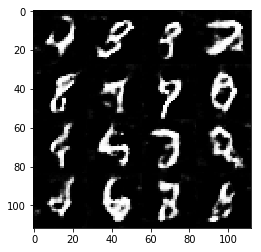

Epoch 1/2... Discriminator Loss: 1.4979 ... Generator Loss: 0.3763
Epoch 1/2... Discriminator Loss: 1.3827 ... Generator Loss: 0.4151
Epoch 1/2... Discriminator Loss: 1.4794 ... Generator Loss: 0.3471
Epoch 1/2... Discriminator Loss: 1.1958 ... Generator Loss: 0.9978
Epoch 1/2... Discriminator Loss: 1.2720 ... Generator Loss: 0.8046
Epoch 1/2... Discriminator Loss: 1.4750 ... Generator Loss: 1.5785
Epoch 1/2... Discriminator Loss: 1.2676 ... Generator Loss: 0.5882
Epoch 1/2... Discriminator Loss: 1.5875 ... Generator Loss: 0.3605
Epoch 1/2... Discriminator Loss: 1.4792 ... Generator Loss: 0.3882
Epoch 1/2... Discriminator Loss: 1.4120 ... Generator Loss: 0.3648


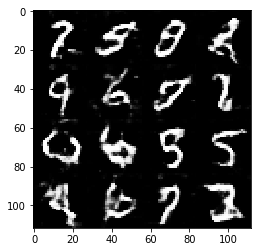

Epoch 1/2... Discriminator Loss: 1.1893 ... Generator Loss: 0.5998
Epoch 1/2... Discriminator Loss: 1.4083 ... Generator Loss: 1.4850
Epoch 1/2... Discriminator Loss: 1.4105 ... Generator Loss: 1.2721
Epoch 1/2... Discriminator Loss: 1.2411 ... Generator Loss: 1.0452
Epoch 1/2... Discriminator Loss: 1.1573 ... Generator Loss: 1.1326
Epoch 1/2... Discriminator Loss: 1.4124 ... Generator Loss: 1.0847
Epoch 1/2... Discriminator Loss: 1.0738 ... Generator Loss: 0.8927
Epoch 1/2... Discriminator Loss: 1.5740 ... Generator Loss: 0.3538
Epoch 1/2... Discriminator Loss: 1.3864 ... Generator Loss: 0.4719
Epoch 1/2... Discriminator Loss: 1.4421 ... Generator Loss: 0.4339


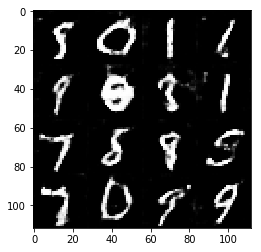

Epoch 1/2... Discriminator Loss: 1.2889 ... Generator Loss: 0.5607
Epoch 1/2... Discriminator Loss: 1.6335 ... Generator Loss: 0.3244
Epoch 1/2... Discriminator Loss: 1.4471 ... Generator Loss: 0.4539
Epoch 1/2... Discriminator Loss: 1.1510 ... Generator Loss: 0.7104
Epoch 1/2... Discriminator Loss: 1.6966 ... Generator Loss: 0.2784
Epoch 1/2... Discriminator Loss: 1.3055 ... Generator Loss: 0.5147
Epoch 1/2... Discriminator Loss: 1.3473 ... Generator Loss: 0.4424
Epoch 1/2... Discriminator Loss: 1.4192 ... Generator Loss: 0.4244
Epoch 1/2... Discriminator Loss: 1.3023 ... Generator Loss: 0.3838
Epoch 1/2... Discriminator Loss: 1.3629 ... Generator Loss: 0.4689


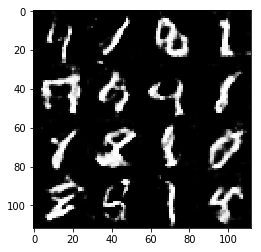

Epoch 1/2... Discriminator Loss: 1.2503 ... Generator Loss: 0.5075
Epoch 1/2... Discriminator Loss: 1.2643 ... Generator Loss: 0.5120
Epoch 1/2... Discriminator Loss: 1.3243 ... Generator Loss: 0.5425
Epoch 2/2... Discriminator Loss: 1.5190 ... Generator Loss: 0.3768
Epoch 2/2... Discriminator Loss: 1.1368 ... Generator Loss: 0.7450
Epoch 2/2... Discriminator Loss: 1.4993 ... Generator Loss: 1.7868
Epoch 2/2... Discriminator Loss: 1.1546 ... Generator Loss: 1.4770
Epoch 2/2... Discriminator Loss: 1.2157 ... Generator Loss: 1.4005
Epoch 2/2... Discriminator Loss: 1.2348 ... Generator Loss: 1.5975
Epoch 2/2... Discriminator Loss: 1.8066 ... Generator Loss: 2.3098


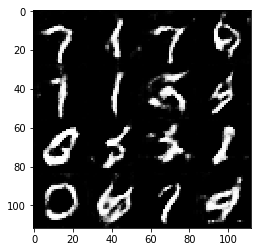

Epoch 2/2... Discriminator Loss: 1.1462 ... Generator Loss: 1.2292
Epoch 2/2... Discriminator Loss: 0.9939 ... Generator Loss: 1.0446
Epoch 2/2... Discriminator Loss: 1.5991 ... Generator Loss: 0.3491
Epoch 2/2... Discriminator Loss: 1.5044 ... Generator Loss: 0.3882
Epoch 2/2... Discriminator Loss: 1.4419 ... Generator Loss: 0.3611
Epoch 2/2... Discriminator Loss: 1.3063 ... Generator Loss: 0.4874
Epoch 2/2... Discriminator Loss: 1.5807 ... Generator Loss: 0.3664
Epoch 2/2... Discriminator Loss: 1.0684 ... Generator Loss: 0.8178
Epoch 2/2... Discriminator Loss: 1.0212 ... Generator Loss: 1.1620
Epoch 2/2... Discriminator Loss: 1.4488 ... Generator Loss: 1.7364


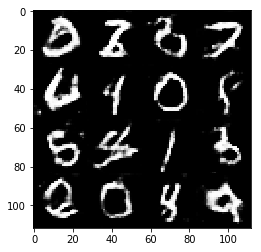

Epoch 2/2... Discriminator Loss: 0.9884 ... Generator Loss: 1.5101
Epoch 2/2... Discriminator Loss: 1.0628 ... Generator Loss: 1.3195
Epoch 2/2... Discriminator Loss: 1.1489 ... Generator Loss: 1.0894
Epoch 2/2... Discriminator Loss: 1.5588 ... Generator Loss: 0.3237
Epoch 2/2... Discriminator Loss: 0.9360 ... Generator Loss: 0.8079
Epoch 2/2... Discriminator Loss: 1.3281 ... Generator Loss: 0.4734
Epoch 2/2... Discriminator Loss: 1.1871 ... Generator Loss: 0.6508
Epoch 2/2... Discriminator Loss: 1.7195 ... Generator Loss: 0.3082
Epoch 2/2... Discriminator Loss: 1.4124 ... Generator Loss: 0.4477
Epoch 2/2... Discriminator Loss: 1.2679 ... Generator Loss: 0.6020


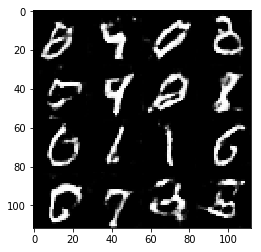

Epoch 2/2... Discriminator Loss: 1.5433 ... Generator Loss: 0.3816
Epoch 2/2... Discriminator Loss: 1.0110 ... Generator Loss: 1.1475
Epoch 2/2... Discriminator Loss: 1.1008 ... Generator Loss: 1.2178
Epoch 2/2... Discriminator Loss: 1.5448 ... Generator Loss: 2.0355
Epoch 2/2... Discriminator Loss: 1.0943 ... Generator Loss: 0.8477
Epoch 2/2... Discriminator Loss: 1.6259 ... Generator Loss: 0.3014
Epoch 2/2... Discriminator Loss: 0.9737 ... Generator Loss: 1.0526
Epoch 2/2... Discriminator Loss: 1.0477 ... Generator Loss: 1.2123
Epoch 2/2... Discriminator Loss: 0.7411 ... Generator Loss: 1.5176
Epoch 2/2... Discriminator Loss: 1.2376 ... Generator Loss: 1.8422


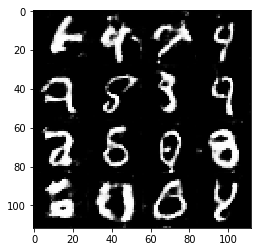

Epoch 2/2... Discriminator Loss: 0.7892 ... Generator Loss: 1.1972
Epoch 2/2... Discriminator Loss: 1.2876 ... Generator Loss: 1.5078
Epoch 2/2... Discriminator Loss: 1.2097 ... Generator Loss: 1.2969
Epoch 2/2... Discriminator Loss: 0.9214 ... Generator Loss: 1.4786
Epoch 2/2... Discriminator Loss: 1.3349 ... Generator Loss: 1.6836
Epoch 2/2... Discriminator Loss: 0.8136 ... Generator Loss: 1.3527
Epoch 2/2... Discriminator Loss: 1.3515 ... Generator Loss: 1.8528
Epoch 2/2... Discriminator Loss: 0.9004 ... Generator Loss: 0.9513
Epoch 2/2... Discriminator Loss: 1.3478 ... Generator Loss: 1.7678
Epoch 2/2... Discriminator Loss: 0.9013 ... Generator Loss: 1.4690


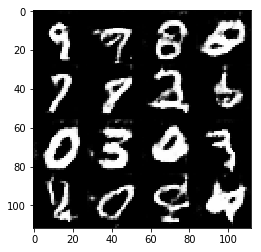

Epoch 2/2... Discriminator Loss: 0.9805 ... Generator Loss: 1.2893
Epoch 2/2... Discriminator Loss: 0.9745 ... Generator Loss: 0.8526
Epoch 2/2... Discriminator Loss: 1.3435 ... Generator Loss: 1.3979
Epoch 2/2... Discriminator Loss: 1.0093 ... Generator Loss: 1.4859
Epoch 2/2... Discriminator Loss: 1.3384 ... Generator Loss: 0.4337
Epoch 2/2... Discriminator Loss: 1.3200 ... Generator Loss: 0.4501
Epoch 2/2... Discriminator Loss: 0.9886 ... Generator Loss: 0.5895
Epoch 2/2... Discriminator Loss: 1.2601 ... Generator Loss: 0.5692
Epoch 2/2... Discriminator Loss: 1.5475 ... Generator Loss: 0.4090
Epoch 2/2... Discriminator Loss: 1.0410 ... Generator Loss: 1.1280


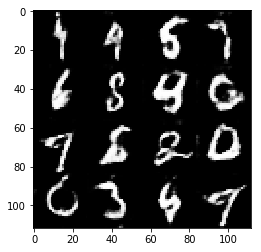

Epoch 2/2... Discriminator Loss: 1.1126 ... Generator Loss: 1.4505
Epoch 2/2... Discriminator Loss: 0.7035 ... Generator Loss: 1.4168
Epoch 2/2... Discriminator Loss: 1.8628 ... Generator Loss: 1.9384
Epoch 2/2... Discriminator Loss: 1.2133 ... Generator Loss: 1.2860
Epoch 2/2... Discriminator Loss: 1.2288 ... Generator Loss: 0.7212
Epoch 2/2... Discriminator Loss: 0.8028 ... Generator Loss: 1.3104
Epoch 2/2... Discriminator Loss: 1.0312 ... Generator Loss: 1.2559
Epoch 2/2... Discriminator Loss: 1.2085 ... Generator Loss: 1.6360
Epoch 2/2... Discriminator Loss: 1.1781 ... Generator Loss: 1.7971
Epoch 2/2... Discriminator Loss: 0.9851 ... Generator Loss: 1.3481


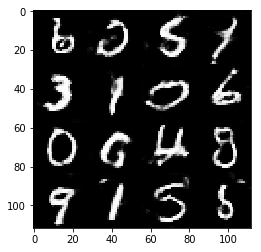

Epoch 2/2... Discriminator Loss: 1.1974 ... Generator Loss: 1.6826
Epoch 2/2... Discriminator Loss: 1.0532 ... Generator Loss: 1.1748
Epoch 2/2... Discriminator Loss: 0.7389 ... Generator Loss: 1.6119
Epoch 2/2... Discriminator Loss: 1.1349 ... Generator Loss: 1.5088
Epoch 2/2... Discriminator Loss: 1.0031 ... Generator Loss: 0.8136
Epoch 2/2... Discriminator Loss: 1.2432 ... Generator Loss: 0.5227
Epoch 2/2... Discriminator Loss: 1.0953 ... Generator Loss: 1.2084
Epoch 2/2... Discriminator Loss: 1.3886 ... Generator Loss: 1.4937
Epoch 2/2... Discriminator Loss: 0.8647 ... Generator Loss: 1.9708
Epoch 2/2... Discriminator Loss: 0.8917 ... Generator Loss: 1.3315


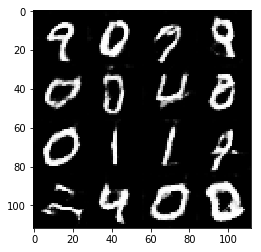

Epoch 2/2... Discriminator Loss: 0.8851 ... Generator Loss: 1.4120
Epoch 2/2... Discriminator Loss: 0.9438 ... Generator Loss: 1.2338
Epoch 2/2... Discriminator Loss: 0.6865 ... Generator Loss: 1.4586
Epoch 2/2... Discriminator Loss: 1.4742 ... Generator Loss: 1.8554
Epoch 2/2... Discriminator Loss: 0.9954 ... Generator Loss: 0.9081
Epoch 2/2... Discriminator Loss: 0.8179 ... Generator Loss: 1.5356
Epoch 2/2... Discriminator Loss: 1.6092 ... Generator Loss: 1.4964
Epoch 2/2... Discriminator Loss: 1.1343 ... Generator Loss: 0.9611
Epoch 2/2... Discriminator Loss: 1.1020 ... Generator Loss: 1.4782
Epoch 2/2... Discriminator Loss: 0.8387 ... Generator Loss: 1.4372


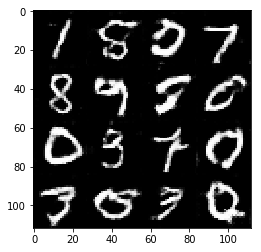

Epoch 2/2... Discriminator Loss: 1.1426 ... Generator Loss: 0.5874
Epoch 2/2... Discriminator Loss: 1.1490 ... Generator Loss: 0.6979
Epoch 2/2... Discriminator Loss: 0.9718 ... Generator Loss: 1.7220
Epoch 2/2... Discriminator Loss: 0.9824 ... Generator Loss: 1.7318
Epoch 2/2... Discriminator Loss: 1.0753 ... Generator Loss: 1.8867
Epoch 2/2... Discriminator Loss: 1.0203 ... Generator Loss: 0.9922
Epoch 2/2... Discriminator Loss: 0.8144 ... Generator Loss: 1.4202


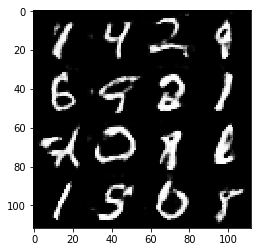

In [20]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.1

# https://discussions.udacity.com/t/project-facegeneration-indexerror-list-index-out-of-range/246401
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5257 ... Generator Loss: 1.6117
Epoch 1/1... Discriminator Loss: 0.3378 ... Generator Loss: 1.8979
Epoch 1/1... Discriminator Loss: 0.3462 ... Generator Loss: 2.3783
Epoch 1/1... Discriminator Loss: 0.5311 ... Generator Loss: 3.3878
Epoch 1/1... Discriminator Loss: 0.3718 ... Generator Loss: 3.9650
Epoch 1/1... Discriminator Loss: 0.7687 ... Generator Loss: 4.7823
Epoch 1/1... Discriminator Loss: 1.1337 ... Generator Loss: 5.6738
Epoch 1/1... Discriminator Loss: 0.2633 ... Generator Loss: 3.6090
Epoch 1/1... Discriminator Loss: 0.5011 ... Generator Loss: 1.9143
Epoch 1/1... Discriminator Loss: 0.4195 ... Generator Loss: 1.4098


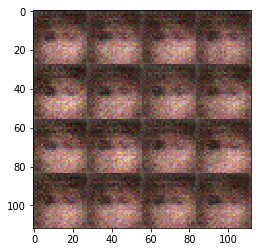

Epoch 1/1... Discriminator Loss: 0.4014 ... Generator Loss: 2.5609
Epoch 1/1... Discriminator Loss: 0.3212 ... Generator Loss: 3.7503
Epoch 1/1... Discriminator Loss: 0.5459 ... Generator Loss: 1.8864
Epoch 1/1... Discriminator Loss: 0.4113 ... Generator Loss: 1.9533
Epoch 1/1... Discriminator Loss: 0.2476 ... Generator Loss: 2.7049
Epoch 1/1... Discriminator Loss: 0.4836 ... Generator Loss: 2.6125
Epoch 1/1... Discriminator Loss: 0.3169 ... Generator Loss: 2.2244
Epoch 1/1... Discriminator Loss: 0.4110 ... Generator Loss: 1.8273
Epoch 1/1... Discriminator Loss: 0.7152 ... Generator Loss: 1.2079
Epoch 1/1... Discriminator Loss: 0.2565 ... Generator Loss: 2.9205


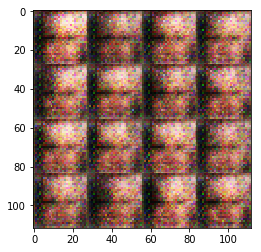

Epoch 1/1... Discriminator Loss: 0.6842 ... Generator Loss: 1.4345
Epoch 1/1... Discriminator Loss: 0.4584 ... Generator Loss: 1.7769
Epoch 1/1... Discriminator Loss: 0.8445 ... Generator Loss: 1.0832
Epoch 1/1... Discriminator Loss: 0.6228 ... Generator Loss: 1.6872
Epoch 1/1... Discriminator Loss: 1.0723 ... Generator Loss: 0.5706
Epoch 1/1... Discriminator Loss: 0.8242 ... Generator Loss: 0.8844
Epoch 1/1... Discriminator Loss: 0.7770 ... Generator Loss: 1.2171
Epoch 1/1... Discriminator Loss: 0.6284 ... Generator Loss: 1.5649
Epoch 1/1... Discriminator Loss: 0.8147 ... Generator Loss: 1.4613
Epoch 1/1... Discriminator Loss: 0.5185 ... Generator Loss: 1.9612


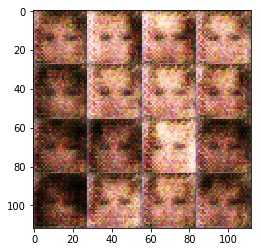

Epoch 1/1... Discriminator Loss: 0.6663 ... Generator Loss: 1.5457
Epoch 1/1... Discriminator Loss: 0.7051 ... Generator Loss: 1.9166
Epoch 1/1... Discriminator Loss: 0.6963 ... Generator Loss: 1.0339
Epoch 1/1... Discriminator Loss: 0.4981 ... Generator Loss: 1.9103
Epoch 1/1... Discriminator Loss: 0.6678 ... Generator Loss: 1.9369
Epoch 1/1... Discriminator Loss: 0.9054 ... Generator Loss: 2.9254
Epoch 1/1... Discriminator Loss: 0.9525 ... Generator Loss: 2.2845
Epoch 1/1... Discriminator Loss: 0.8473 ... Generator Loss: 1.5919
Epoch 1/1... Discriminator Loss: 0.9114 ... Generator Loss: 2.9310
Epoch 1/1... Discriminator Loss: 0.7191 ... Generator Loss: 2.0839


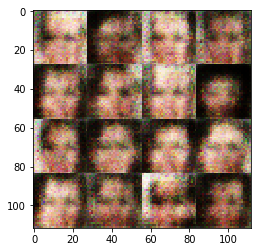

Epoch 1/1... Discriminator Loss: 0.9062 ... Generator Loss: 1.3750
Epoch 1/1... Discriminator Loss: 0.7433 ... Generator Loss: 1.8498
Epoch 1/1... Discriminator Loss: 1.0132 ... Generator Loss: 2.3357
Epoch 1/1... Discriminator Loss: 0.9228 ... Generator Loss: 1.9110
Epoch 1/1... Discriminator Loss: 1.0798 ... Generator Loss: 2.0274
Epoch 1/1... Discriminator Loss: 0.9017 ... Generator Loss: 2.2419
Epoch 1/1... Discriminator Loss: 0.7691 ... Generator Loss: 1.3024
Epoch 1/1... Discriminator Loss: 0.8099 ... Generator Loss: 1.2171
Epoch 1/1... Discriminator Loss: 0.8137 ... Generator Loss: 2.3474
Epoch 1/1... Discriminator Loss: 1.1550 ... Generator Loss: 2.8735


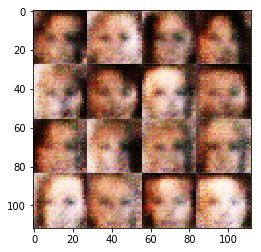

Epoch 1/1... Discriminator Loss: 0.9632 ... Generator Loss: 2.4454
Epoch 1/1... Discriminator Loss: 0.8054 ... Generator Loss: 1.7272
Epoch 1/1... Discriminator Loss: 1.1451 ... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.0261 ... Generator Loss: 1.0822
Epoch 1/1... Discriminator Loss: 1.1256 ... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 0.8411 ... Generator Loss: 0.9987
Epoch 1/1... Discriminator Loss: 0.9205 ... Generator Loss: 1.4112
Epoch 1/1... Discriminator Loss: 1.5018 ... Generator Loss: 0.4137
Epoch 1/1... Discriminator Loss: 1.1011 ... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 0.9973 ... Generator Loss: 0.8145


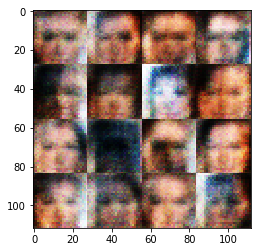

Epoch 1/1... Discriminator Loss: 0.7583 ... Generator Loss: 1.2590
Epoch 1/1... Discriminator Loss: 0.9036 ... Generator Loss: 0.9732
Epoch 1/1... Discriminator Loss: 0.8216 ... Generator Loss: 2.2804
Epoch 1/1... Discriminator Loss: 1.0005 ... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.0985 ... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 0.8793 ... Generator Loss: 1.0977
Epoch 1/1... Discriminator Loss: 0.8153 ... Generator Loss: 1.5596
Epoch 1/1... Discriminator Loss: 0.9189 ... Generator Loss: 1.5982
Epoch 1/1... Discriminator Loss: 1.0411 ... Generator Loss: 2.4007
Epoch 1/1... Discriminator Loss: 0.9042 ... Generator Loss: 2.1315


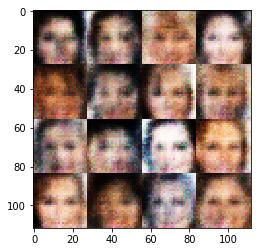

Epoch 1/1... Discriminator Loss: 0.7881 ... Generator Loss: 1.4840
Epoch 1/1... Discriminator Loss: 0.7216 ... Generator Loss: 1.5509
Epoch 1/1... Discriminator Loss: 0.9155 ... Generator Loss: 1.0167
Epoch 1/1... Discriminator Loss: 0.7460 ... Generator Loss: 1.2473
Epoch 1/1... Discriminator Loss: 0.9303 ... Generator Loss: 1.3468
Epoch 1/1... Discriminator Loss: 0.8098 ... Generator Loss: 1.7960
Epoch 1/1... Discriminator Loss: 0.8691 ... Generator Loss: 1.4016
Epoch 1/1... Discriminator Loss: 0.9616 ... Generator Loss: 1.4297
Epoch 1/1... Discriminator Loss: 0.9745 ... Generator Loss: 1.1264
Epoch 1/1... Discriminator Loss: 0.8042 ... Generator Loss: 1.1888


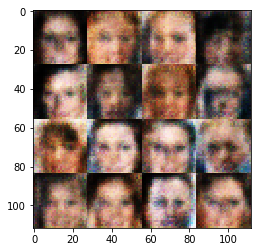

Epoch 1/1... Discriminator Loss: 0.6989 ... Generator Loss: 1.7606
Epoch 1/1... Discriminator Loss: 0.9327 ... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 0.6835 ... Generator Loss: 1.5311
Epoch 1/1... Discriminator Loss: 0.7215 ... Generator Loss: 1.2270
Epoch 1/1... Discriminator Loss: 0.9189 ... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 0.9481 ... Generator Loss: 1.6067
Epoch 1/1... Discriminator Loss: 0.8020 ... Generator Loss: 1.3562
Epoch 1/1... Discriminator Loss: 0.6757 ... Generator Loss: 1.6339
Epoch 1/1... Discriminator Loss: 0.9939 ... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 0.6719 ... Generator Loss: 2.2849


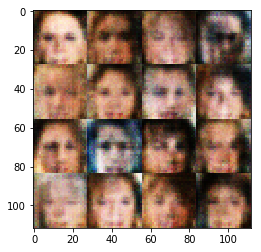

Epoch 1/1... Discriminator Loss: 0.7042 ... Generator Loss: 2.0003
Epoch 1/1... Discriminator Loss: 0.7880 ... Generator Loss: 1.9899
Epoch 1/1... Discriminator Loss: 0.9239 ... Generator Loss: 0.9152
Epoch 1/1... Discriminator Loss: 0.6781 ... Generator Loss: 1.5304
Epoch 1/1... Discriminator Loss: 0.7808 ... Generator Loss: 1.6584
Epoch 1/1... Discriminator Loss: 0.7819 ... Generator Loss: 1.0726
Epoch 1/1... Discriminator Loss: 0.7094 ... Generator Loss: 1.6014
Epoch 1/1... Discriminator Loss: 1.0554 ... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 0.7100 ... Generator Loss: 1.4147
Epoch 1/1... Discriminator Loss: 0.8670 ... Generator Loss: 0.8490


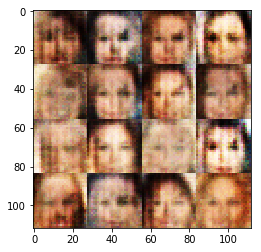

Epoch 1/1... Discriminator Loss: 0.9300 ... Generator Loss: 0.9532
Epoch 1/1... Discriminator Loss: 0.8169 ... Generator Loss: 1.0141
Epoch 1/1... Discriminator Loss: 0.8397 ... Generator Loss: 1.2176
Epoch 1/1... Discriminator Loss: 0.9715 ... Generator Loss: 2.6998
Epoch 1/1... Discriminator Loss: 0.6865 ... Generator Loss: 1.4996
Epoch 1/1... Discriminator Loss: 0.8739 ... Generator Loss: 2.0813
Epoch 1/1... Discriminator Loss: 0.7051 ... Generator Loss: 1.3460
Epoch 1/1... Discriminator Loss: 1.1277 ... Generator Loss: 2.5837
Epoch 1/1... Discriminator Loss: 0.8355 ... Generator Loss: 1.1505
Epoch 1/1... Discriminator Loss: 1.0097 ... Generator Loss: 0.6544


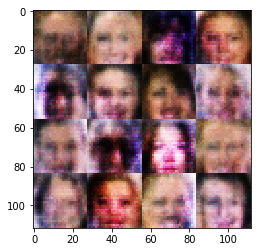

Epoch 1/1... Discriminator Loss: 0.9715 ... Generator Loss: 0.8617
Epoch 1/1... Discriminator Loss: 0.9633 ... Generator Loss: 1.2344
Epoch 1/1... Discriminator Loss: 1.0656 ... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 0.9546 ... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 0.9694 ... Generator Loss: 0.9567
Epoch 1/1... Discriminator Loss: 0.9653 ... Generator Loss: 1.1757
Epoch 1/1... Discriminator Loss: 0.9253 ... Generator Loss: 1.2839
Epoch 1/1... Discriminator Loss: 1.0440 ... Generator Loss: 1.0169
Epoch 1/1... Discriminator Loss: 1.0732 ... Generator Loss: 1.9807
Epoch 1/1... Discriminator Loss: 0.8569 ... Generator Loss: 1.4422


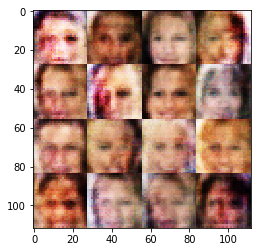

Epoch 1/1... Discriminator Loss: 0.8099 ... Generator Loss: 1.6854
Epoch 1/1... Discriminator Loss: 0.8453 ... Generator Loss: 1.4270
Epoch 1/1... Discriminator Loss: 1.2363 ... Generator Loss: 0.5780
Epoch 1/1... Discriminator Loss: 1.2905 ... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 0.9454 ... Generator Loss: 1.9863
Epoch 1/1... Discriminator Loss: 0.9219 ... Generator Loss: 1.2455
Epoch 1/1... Discriminator Loss: 1.0320 ... Generator Loss: 1.0069
Epoch 1/1... Discriminator Loss: 0.7963 ... Generator Loss: 1.4679
Epoch 1/1... Discriminator Loss: 1.0185 ... Generator Loss: 1.2880
Epoch 1/1... Discriminator Loss: 0.8742 ... Generator Loss: 1.3134


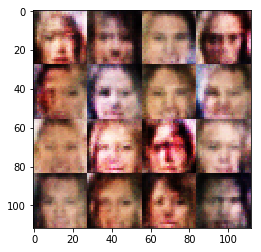

Epoch 1/1... Discriminator Loss: 1.1475 ... Generator Loss: 2.2024
Epoch 1/1... Discriminator Loss: 1.0289 ... Generator Loss: 1.9722
Epoch 1/1... Discriminator Loss: 0.9978 ... Generator Loss: 1.4284
Epoch 1/1... Discriminator Loss: 0.9668 ... Generator Loss: 1.2410
Epoch 1/1... Discriminator Loss: 0.8285 ... Generator Loss: 1.5594
Epoch 1/1... Discriminator Loss: 0.9267 ... Generator Loss: 1.6551
Epoch 1/1... Discriminator Loss: 0.8558 ... Generator Loss: 1.6108
Epoch 1/1... Discriminator Loss: 0.8989 ... Generator Loss: 1.0466
Epoch 1/1... Discriminator Loss: 1.0147 ... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 0.8994 ... Generator Loss: 2.1393


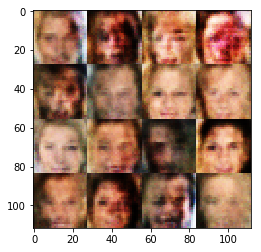

Epoch 1/1... Discriminator Loss: 1.0867 ... Generator Loss: 1.7172
Epoch 1/1... Discriminator Loss: 0.8415 ... Generator Loss: 1.3166
Epoch 1/1... Discriminator Loss: 1.0368 ... Generator Loss: 1.5722
Epoch 1/1... Discriminator Loss: 1.0009 ... Generator Loss: 1.0303
Epoch 1/1... Discriminator Loss: 0.9182 ... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 0.8971 ... Generator Loss: 1.1965
Epoch 1/1... Discriminator Loss: 0.9243 ... Generator Loss: 1.1089
Epoch 1/1... Discriminator Loss: 0.8504 ... Generator Loss: 1.5704
Epoch 1/1... Discriminator Loss: 0.9333 ... Generator Loss: 1.0027
Epoch 1/1... Discriminator Loss: 0.9766 ... Generator Loss: 0.6846


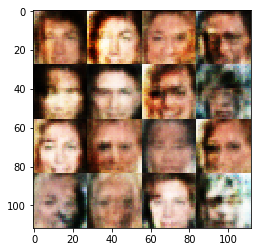

Epoch 1/1... Discriminator Loss: 0.8537 ... Generator Loss: 1.2805
Epoch 1/1... Discriminator Loss: 0.9898 ... Generator Loss: 1.1159
Epoch 1/1... Discriminator Loss: 0.9272 ... Generator Loss: 1.2683
Epoch 1/1... Discriminator Loss: 0.9576 ... Generator Loss: 1.1373
Epoch 1/1... Discriminator Loss: 1.0002 ... Generator Loss: 1.6407
Epoch 1/1... Discriminator Loss: 0.9401 ... Generator Loss: 1.1881
Epoch 1/1... Discriminator Loss: 0.8250 ... Generator Loss: 1.4897
Epoch 1/1... Discriminator Loss: 0.9253 ... Generator Loss: 1.6648
Epoch 1/1... Discriminator Loss: 0.9823 ... Generator Loss: 1.7805
Epoch 1/1... Discriminator Loss: 0.9132 ... Generator Loss: 1.7594


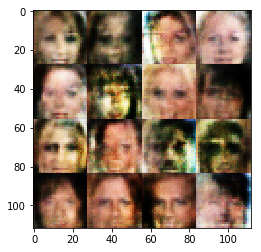

Epoch 1/1... Discriminator Loss: 0.9930 ... Generator Loss: 1.5040
Epoch 1/1... Discriminator Loss: 0.9747 ... Generator Loss: 1.6546
Epoch 1/1... Discriminator Loss: 1.0593 ... Generator Loss: 1.2243
Epoch 1/1... Discriminator Loss: 1.1556 ... Generator Loss: 0.5239
Epoch 1/1... Discriminator Loss: 1.2713 ... Generator Loss: 0.4566
Epoch 1/1... Discriminator Loss: 0.9880 ... Generator Loss: 1.2260
Epoch 1/1... Discriminator Loss: 1.0327 ... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.0643 ... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 0.8599 ... Generator Loss: 0.8925
Epoch 1/1... Discriminator Loss: 1.0428 ... Generator Loss: 0.8456


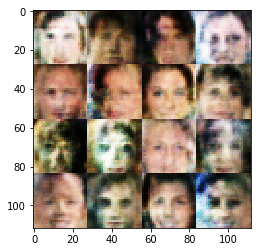

Epoch 1/1... Discriminator Loss: 0.8290 ... Generator Loss: 1.0753
Epoch 1/1... Discriminator Loss: 0.8723 ... Generator Loss: 1.2310
Epoch 1/1... Discriminator Loss: 0.9949 ... Generator Loss: 1.7830
Epoch 1/1... Discriminator Loss: 1.0688 ... Generator Loss: 1.6541
Epoch 1/1... Discriminator Loss: 1.0130 ... Generator Loss: 1.0662
Epoch 1/1... Discriminator Loss: 0.9527 ... Generator Loss: 0.8954
Epoch 1/1... Discriminator Loss: 0.9763 ... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 0.9851 ... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 0.9835 ... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.0294 ... Generator Loss: 1.2388


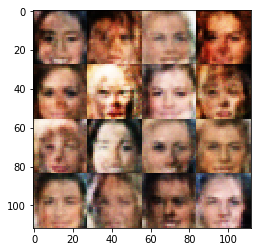

Epoch 1/1... Discriminator Loss: 0.9027 ... Generator Loss: 1.0947
Epoch 1/1... Discriminator Loss: 0.8850 ... Generator Loss: 1.5447
Epoch 1/1... Discriminator Loss: 0.9038 ... Generator Loss: 0.9906
Epoch 1/1... Discriminator Loss: 1.1714 ... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 0.9010 ... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 1.1206 ... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 0.8660 ... Generator Loss: 0.9812
Epoch 1/1... Discriminator Loss: 0.9034 ... Generator Loss: 1.4445
Epoch 1/1... Discriminator Loss: 0.9175 ... Generator Loss: 1.5281
Epoch 1/1... Discriminator Loss: 0.9916 ... Generator Loss: 1.0117


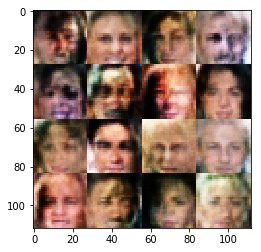

Epoch 1/1... Discriminator Loss: 1.1435 ... Generator Loss: 2.1283
Epoch 1/1... Discriminator Loss: 0.9976 ... Generator Loss: 1.0407
Epoch 1/1... Discriminator Loss: 1.0337 ... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 0.9348 ... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 0.9189 ... Generator Loss: 1.5087
Epoch 1/1... Discriminator Loss: 0.9552 ... Generator Loss: 1.0089
Epoch 1/1... Discriminator Loss: 0.8521 ... Generator Loss: 1.0176
Epoch 1/1... Discriminator Loss: 0.8528 ... Generator Loss: 1.3797
Epoch 1/1... Discriminator Loss: 0.9527 ... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 0.8976 ... Generator Loss: 1.0166


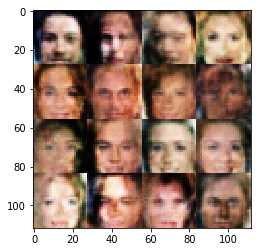

Epoch 1/1... Discriminator Loss: 1.1188 ... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.0350 ... Generator Loss: 1.6187
Epoch 1/1... Discriminator Loss: 0.8797 ... Generator Loss: 1.2517
Epoch 1/1... Discriminator Loss: 0.9646 ... Generator Loss: 1.4795
Epoch 1/1... Discriminator Loss: 1.0643 ... Generator Loss: 1.7918
Epoch 1/1... Discriminator Loss: 0.9667 ... Generator Loss: 1.3976
Epoch 1/1... Discriminator Loss: 0.9275 ... Generator Loss: 1.1322
Epoch 1/1... Discriminator Loss: 1.0000 ... Generator Loss: 1.7007
Epoch 1/1... Discriminator Loss: 1.0266 ... Generator Loss: 1.9260
Epoch 1/1... Discriminator Loss: 0.9096 ... Generator Loss: 1.4717


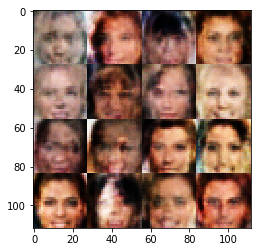

Epoch 1/1... Discriminator Loss: 1.1141 ... Generator Loss: 1.1103
Epoch 1/1... Discriminator Loss: 1.2896 ... Generator Loss: 0.5013
Epoch 1/1... Discriminator Loss: 0.8009 ... Generator Loss: 1.3207
Epoch 1/1... Discriminator Loss: 0.8018 ... Generator Loss: 1.2394
Epoch 1/1... Discriminator Loss: 0.9219 ... Generator Loss: 1.5456
Epoch 1/1... Discriminator Loss: 1.0871 ... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 0.8432 ... Generator Loss: 1.3913
Epoch 1/1... Discriminator Loss: 1.0241 ... Generator Loss: 1.3130
Epoch 1/1... Discriminator Loss: 1.0355 ... Generator Loss: 0.9958
Epoch 1/1... Discriminator Loss: 1.1469 ... Generator Loss: 1.7678


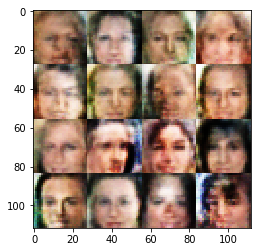

Epoch 1/1... Discriminator Loss: 0.9705 ... Generator Loss: 1.4930
Epoch 1/1... Discriminator Loss: 0.8889 ... Generator Loss: 1.0822
Epoch 1/1... Discriminator Loss: 1.0492 ... Generator Loss: 1.5177
Epoch 1/1... Discriminator Loss: 1.1227 ... Generator Loss: 1.7935
Epoch 1/1... Discriminator Loss: 1.0865 ... Generator Loss: 1.5509
Epoch 1/1... Discriminator Loss: 0.9211 ... Generator Loss: 0.9927
Epoch 1/1... Discriminator Loss: 1.0461 ... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.0750 ... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 0.9862 ... Generator Loss: 0.8352
Epoch 1/1... Discriminator Loss: 0.9664 ... Generator Loss: 1.6564


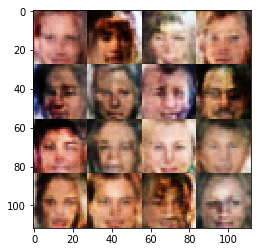

Epoch 1/1... Discriminator Loss: 0.9524 ... Generator Loss: 1.7907
Epoch 1/1... Discriminator Loss: 0.9635 ... Generator Loss: 1.1505
Epoch 1/1... Discriminator Loss: 0.8410 ... Generator Loss: 1.2060
Epoch 1/1... Discriminator Loss: 1.1334 ... Generator Loss: 0.5552
Epoch 1/1... Discriminator Loss: 0.8811 ... Generator Loss: 1.2325
Epoch 1/1... Discriminator Loss: 0.9783 ... Generator Loss: 1.0715
Epoch 1/1... Discriminator Loss: 0.8750 ... Generator Loss: 1.1897
Epoch 1/1... Discriminator Loss: 0.8904 ... Generator Loss: 1.3785
Epoch 1/1... Discriminator Loss: 1.1470 ... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.0520 ... Generator Loss: 0.7863


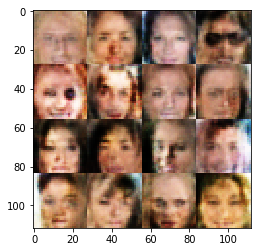

Epoch 1/1... Discriminator Loss: 1.0183 ... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 0.7063 ... Generator Loss: 1.4067
Epoch 1/1... Discriminator Loss: 1.1548 ... Generator Loss: 0.6028
Epoch 1/1... Discriminator Loss: 0.8680 ... Generator Loss: 1.0395
Epoch 1/1... Discriminator Loss: 0.8112 ... Generator Loss: 1.2252
Epoch 1/1... Discriminator Loss: 0.9690 ... Generator Loss: 1.1130
Epoch 1/1... Discriminator Loss: 1.1662 ... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 0.9246 ... Generator Loss: 1.5398
Epoch 1/1... Discriminator Loss: 0.9817 ... Generator Loss: 0.9319
Epoch 1/1... Discriminator Loss: 0.8045 ... Generator Loss: 1.1771


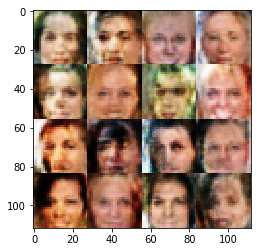

Epoch 1/1... Discriminator Loss: 0.9197 ... Generator Loss: 1.5465
Epoch 1/1... Discriminator Loss: 0.8237 ... Generator Loss: 1.5137
Epoch 1/1... Discriminator Loss: 1.1607 ... Generator Loss: 0.5584
Epoch 1/1... Discriminator Loss: 0.9691 ... Generator Loss: 1.6762
Epoch 1/1... Discriminator Loss: 0.8447 ... Generator Loss: 0.9457
Epoch 1/1... Discriminator Loss: 0.8872 ... Generator Loss: 0.9806
Epoch 1/1... Discriminator Loss: 1.0010 ... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 0.9780 ... Generator Loss: 1.0833
Epoch 1/1... Discriminator Loss: 0.9114 ... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 0.9393 ... Generator Loss: 0.9197


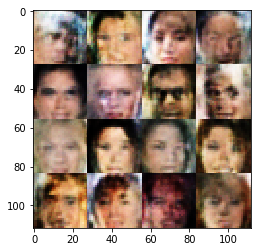

Epoch 1/1... Discriminator Loss: 0.9175 ... Generator Loss: 1.1165
Epoch 1/1... Discriminator Loss: 0.9364 ... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 0.9417 ... Generator Loss: 0.9420
Epoch 1/1... Discriminator Loss: 0.8872 ... Generator Loss: 1.7808
Epoch 1/1... Discriminator Loss: 0.9470 ... Generator Loss: 1.1903
Epoch 1/1... Discriminator Loss: 0.9445 ... Generator Loss: 0.8773
Epoch 1/1... Discriminator Loss: 0.8070 ... Generator Loss: 1.5121
Epoch 1/1... Discriminator Loss: 0.9653 ... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 0.9336 ... Generator Loss: 0.8771
Epoch 1/1... Discriminator Loss: 1.4780 ... Generator Loss: 0.4335


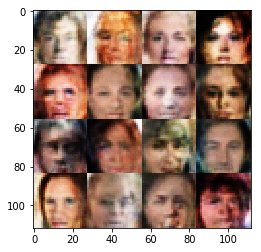

Epoch 1/1... Discriminator Loss: 1.2508 ... Generator Loss: 0.5875
Epoch 1/1... Discriminator Loss: 0.9000 ... Generator Loss: 1.7208
Epoch 1/1... Discriminator Loss: 0.9505 ... Generator Loss: 1.0873
Epoch 1/1... Discriminator Loss: 0.8522 ... Generator Loss: 1.9222
Epoch 1/1... Discriminator Loss: 0.8988 ... Generator Loss: 1.5518
Epoch 1/1... Discriminator Loss: 0.7942 ... Generator Loss: 1.0789
Epoch 1/1... Discriminator Loss: 0.8695 ... Generator Loss: 1.2003
Epoch 1/1... Discriminator Loss: 1.0136 ... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 0.8521 ... Generator Loss: 1.2022
Epoch 1/1... Discriminator Loss: 0.8258 ... Generator Loss: 0.8429


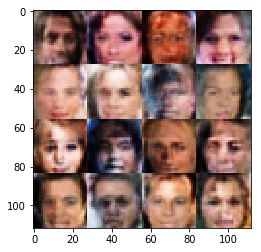

Epoch 1/1... Discriminator Loss: 0.8895 ... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 0.8315 ... Generator Loss: 0.9669
Epoch 1/1... Discriminator Loss: 1.0426 ... Generator Loss: 1.3627
Epoch 1/1... Discriminator Loss: 0.6256 ... Generator Loss: 1.4303
Epoch 1/1... Discriminator Loss: 0.8830 ... Generator Loss: 1.0780
Epoch 1/1... Discriminator Loss: 0.8393 ... Generator Loss: 1.4933
Epoch 1/1... Discriminator Loss: 0.9316 ... Generator Loss: 1.7095
Epoch 1/1... Discriminator Loss: 0.9976 ... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 0.8595 ... Generator Loss: 1.7647
Epoch 1/1... Discriminator Loss: 1.2327 ... Generator Loss: 0.6331


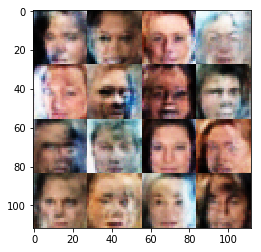

Epoch 1/1... Discriminator Loss: 0.8606 ... Generator Loss: 0.9931
Epoch 1/1... Discriminator Loss: 1.0012 ... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 0.7989 ... Generator Loss: 1.4118
Epoch 1/1... Discriminator Loss: 0.7284 ... Generator Loss: 1.3409
Epoch 1/1... Discriminator Loss: 0.8651 ... Generator Loss: 0.9439
Epoch 1/1... Discriminator Loss: 0.8180 ... Generator Loss: 1.3723
Epoch 1/1... Discriminator Loss: 1.1330 ... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 0.8820 ... Generator Loss: 0.9133
Epoch 1/1... Discriminator Loss: 0.8585 ... Generator Loss: 0.9487
Epoch 1/1... Discriminator Loss: 0.9913 ... Generator Loss: 1.8228


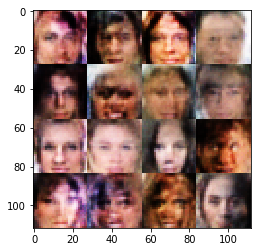

Epoch 1/1... Discriminator Loss: 1.2883 ... Generator Loss: 0.5306
Epoch 1/1... Discriminator Loss: 0.7436 ... Generator Loss: 1.3399
Epoch 1/1... Discriminator Loss: 1.0997 ... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 0.8405 ... Generator Loss: 1.2173
Epoch 1/1... Discriminator Loss: 0.8274 ... Generator Loss: 1.4886
Epoch 1/1... Discriminator Loss: 1.0796 ... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 0.8115 ... Generator Loss: 1.1021
Epoch 1/1... Discriminator Loss: 0.8465 ... Generator Loss: 1.5663
Epoch 1/1... Discriminator Loss: 0.9202 ... Generator Loss: 0.8980
Epoch 1/1... Discriminator Loss: 0.8940 ... Generator Loss: 1.1466


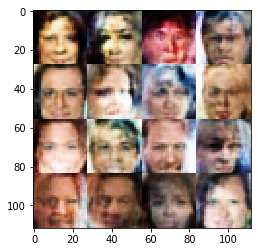

Epoch 1/1... Discriminator Loss: 0.6708 ... Generator Loss: 1.2254
Epoch 1/1... Discriminator Loss: 0.6371 ... Generator Loss: 2.0487
Epoch 1/1... Discriminator Loss: 1.0585 ... Generator Loss: 1.3304
Epoch 1/1... Discriminator Loss: 0.9026 ... Generator Loss: 0.9497
Epoch 1/1... Discriminator Loss: 0.9469 ... Generator Loss: 1.1621
Epoch 1/1... Discriminator Loss: 1.0883 ... Generator Loss: 0.6843


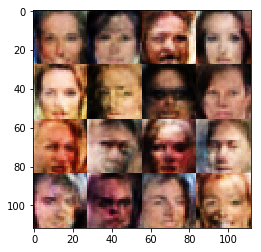

In [21]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.